In [1]:
import os
import numpy as np
import pandas as pd
import shutil
from read_roi import read_roi_file
import tifffile
import matplotlib.pyplot as plt
import create_mask_for_region
from datetime import datetime
from contour_visualization import *

#import shap
# read heatmap plots
#import Heatmap_plots as hmp
import seaborn as sns
import pickle
import tifffile as tiff

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

In [2]:
# set figure key
figure_key = 'Figure7'

In [3]:
# set paths
result_paths = r"\\10.159.50.7\analysis2\Ken\LSMS\Opioid"
rootpath = r"G:\My Drive\Opioid_whole_brain_manuscript"
metapath = os.path.join(rootpath,"meta")
analysis_resultpath = os.path.join(rootpath,"result")
analysis_root_figurepath = os.path.join(rootpath,"figure")
analysis_figurepath = os.path.join(analysis_root_figurepath,figure_key)
for path in [analysis_resultpath,analysis_root_figurepath,analysis_figurepath]:
    if not os.path.exists(path):
        os.mkdir(path)

# load meta info of the files
metadf = pd.read_csv(os.path.join(metapath,"OP_meta.csv"),index_col= False)
# temporary drop of A7 due to missing data
metadf = metadf[metadf.ID != 'A7'].reset_index(drop = True)
# load brain atlas to register
atlas_df = pd.read_csv(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\atlas_info_KimRef_FPbasedLabel_v4.0_brain_with_size_with_curated_with_cleaned_acronyms.csv",index_col = False)
metacolumns = ['id','acronym','parent_acronym','parent_id','structure_order']
contour_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v2.9_contour_map.tif")
# retrieve list of files
fnames =  [f for f in metadf.fname.values if 'DONE' in f]

In [4]:
#Conditions = metadf.Condition.unique()
# Use only morphine related groups
Conditions = ['Saline','Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine','Chronic_Morphine_21','Withdrawal_Morphine_21',]
print(Conditions)

# subset the meta dataframe
metadf = metadf[metadf.Condition.isin(Conditions)]

['Saline', 'Acute_Morphine', 'Chronic_Morphine', 'Withdrawal_Morphine', 'Chronic_Morphine_21', 'Withdrawal_Morphine_21']


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from adjustText import adjust_text

# Set matplotlib parameters for white text on transparent background
plt.rcParams.update({
    'figure.facecolor': 'none',  # Transparent figure background
    'axes.facecolor': 'none',    # Transparent axes background
    'axes.edgecolor': 'black',   # White axes edge color
    'axes.labelcolor': 'black',  # White axis labels
    'xtick.color': 'black',      # White tick labels
    'ytick.color': 'black',      # White tick labels
    'legend.facecolor': 'none',  # Transparent legend background
    'legend.edgecolor': 'none',  # Transparent legend edgecolor
    'text.color': 'black',       # White text color
    'font.family':'Arial',
    'pdf.fonttype':42,
    'ps.fonttype':42,
   
})
#important for text to be detected when importing saved figures into illustrator


In [6]:
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'rb') as handle:
    curated_acronyms = pickle.load(handle)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'rb') as handle:
    ancestor_curated_acronyms = pickle.load(handle,)

In [7]:
default_depth = 4
# set heatmap variables
vmin= -5
vmax = 10

#Conditions = metadf.Condition.unique()
# Use only morphine related groups
Conditions = ['Saline','Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine','Chronic_Morphine_21','Withdrawal_Morphine_21',]
print(Conditions)
#Condition_figure_name = ['Saline','Acute','Chronic 1 day','W.D. 1 day','Chronic 21 days','W.D. 21 days'] # changed this to betterones
Condition_figure_name = ['Saline','Acute','Chronic','Early WD','Re-exposure','Late WD'] 
Condition_color = ['gray','lime','orange','cyan','blue','purple']
# subset the meta dataframe
metadf = metadf[metadf.Condition.isin(Conditions)]

# load and subset dataframes
pivot_heatmap_df = pd.read_csv(os.path.join(analysis_resultpath,'long_pivoted_heatmap_df_with_normalized_density.csv'),index_col = 0)
pivot_heatmap_df = pivot_heatmap_df[metadf[metadf.Condition.isin(Conditions)]['ID'].values]
merge_df  = pd.read_csv(os.path.join(analysis_resultpath,'Ex_639_Ch2_stitched_long_merge_Annotated_counts_with_leaf_with_density_with_normalized_density.csv'),index_col = 0)
merge_df = merge_df[merge_df.Condition.isin(Conditions)]
# Load the acronyms for plotting
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'rb') as handle:
    curated_acronyms = pickle.load(handle)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'rb') as handle:
    ancestor_curated_acronyms = pickle.load(handle,)


['Saline', 'Acute_Morphine', 'Chronic_Morphine', 'Withdrawal_Morphine', 'Chronic_Morphine_21', 'Withdrawal_Morphine_21']


remove HB and CBL from the list of ancestores

In [8]:
# Update the ancestor curated acronyms so it matches the tree devisions
unique_ancestor_curated_acronyms = ['Isocortex','OLF','HPF','CTXsp','STR','PAL','TH','HY','MB',]
#unique_ancestor_curated_acronyms = ['Isocortex','OLF','HPF','CTXsp','STR','PAL','TH','HY','MB','HB','CBL']

# get a list of idx for the ancestors
ancestor_names = [atlas_df.loc[atlas_df.acronym == f,'name'].values[0] for f in unique_ancestor_curated_acronyms]
ancestor_idxs = [atlas_df.loc[atlas_df.acronym == f,'id'].values[0] for f in unique_ancestor_curated_acronyms]
'''
curated_acronyms = []
ancestor_curated_acronyms = []
for idx,i in enumerate(ancestor_idxs):
    create_mask_for_region.get_subregions(atlas_df,i,return_original = True)
    tdf = create_mask_for_region.get_subregions(atlas_df,i,return_original = True)
    curated_acronyms += list(tdf[tdf.Curated_list].acronym)
    ancestor_curated_acronyms += [unique_ancestor_curated_acronyms[idx]]*tdf[tdf.Curated_list].shape[0]

# save the new list of acronyms
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'wb') as handle:
    pickle.dump(curated_acronyms,handle,)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'wb') as handle:
    pickle.dump(ancestor_curated_acronyms,handle,)'''

"\ncurated_acronyms = []\nancestor_curated_acronyms = []\nfor idx,i in enumerate(ancestor_idxs):\n    create_mask_for_region.get_subregions(atlas_df,i,return_original = True)\n    tdf = create_mask_for_region.get_subregions(atlas_df,i,return_original = True)\n    curated_acronyms += list(tdf[tdf.Curated_list].acronym)\n    ancestor_curated_acronyms += [unique_ancestor_curated_acronyms[idx]]*tdf[tdf.Curated_list].shape[0]\n\n# save the new list of acronyms\nwith open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'wb') as handle:\n    pickle.dump(curated_acronyms,handle,)\n\nwith open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'wb') as handle:\n    pickle.dump(ancestor_curated_acronyms,handle,)"

remove CBL and MB subtree from the atlas file and the merge_df

In [9]:
# remove CBL and MB subtree from the data. These regions had bad registration quality and low interest
remove_ancestor_ids = atlas_df[(atlas_df.acronym == 'HB') | (atlas_df.acronym == 'CBL')]['id'].values
remove_df = pd.concat([create_mask_for_region.get_subregions(atlas_df,idx,return_original = True) for idx in remove_ancestor_ids],axis = 0)
sub_atlas_df = atlas_df.set_index(['id']).drop(remove_df['id'].values)
merge_df = merge_df[merge_df.acronym.isin(sub_atlas_df.acronym.unique())]

set up the metacolumns to be compatible for GLM

In [10]:
# load meta info of the files
metadf['age'] = [(datetime.strptime( pday, '%m/%d/%Y') - datetime.strptime( dob, '%m/%d/%Y')).days for pday,dob in metadf.loc[:,['Date_Perfusion','DOB']].values]
atlasmeta = merge_df.reset_index().loc[merge_df.reset_index().ID =='A1',['id','parent_id','acronym','name','parent_acronym']]

#metaexog = metadf[['Condition','Sex','BW','age','Staining_Batch']]
#metacolumns = ['Saline','Acute_Morphine','Chronic_Morphine','Sex_d','Batch_d']


In [11]:
# change categorical values to dummy chategories dtypes
sex_category = pd.CategoricalDtype(categories=['F', 'M'], ordered=False)
condition_category = pd.CategoricalDtype(categories=Conditions, ordered=True)
batch_category = pd.CategoricalDtype(categories=[1,2,3,4], ordered=False)

merge_df['Sex']             = merge_df['Sex'].astype(sex_category)
merge_df['Condition']       = merge_df['Condition'].astype(condition_category)

merge_df['Staining_Batch']  = merge_df['Staining_Batch'].astype(batch_category)

# create dummy cats
condition_dummies           = pd.get_dummies(merge_df['Condition'])
sex_dummies                 = pd.get_dummies(merge_df['Sex']).loc[:,['F']].rename(columns = {'F':'Sex_d'}) # female 1
batch_dummies = pd.get_dummies(merge_df['Staining_Batch'])
batch_dummies.columns = [f'Batch_{c}_d' for c in range(4)]

merge_df                    = pd.concat([merge_df,condition_dummies,sex_dummies,batch_dummies],axis =1)

In [12]:
# add flags for conditions
#merge_df = pd.merge(merge_df,metadf[['ID','Acute_flag','Chronic_flag','Spontaneous_flag']],left_on = 'ID',right_on = 'ID')

In [13]:
# calculate effect size raw
raw_effect_size_df = merge_df[['acronym','Condition','density']].groupby(['acronym','Condition',]).mean().reset_index()\
.pivot(columns = 'Condition',index = 'acronym',values = 'density')

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_68852\3994839575.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_effect_size_df = merge_df[['acronym','Condition','density']].groupby(['acronym','Condition',]).mean().reset_index()\


In [14]:
atlas_df.loc[atlas_df.acronym.isin(curated_acronyms),['acronym','name']].to_csv(os.path.join(metapath,'clean_curated_acronyms.csv'),index = False)

Prepare heatmaps into a dictionary format

In [15]:
# read an annotated atlas file
atlas_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\LSMS\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v4.0.tif")

# Regressing spatial gene expression data

The gene expression data was collected from the MERFISH dataset from ABI.

The code to collect gene expression data from ABI and convert it to the kim atlas framework is in "collect allen atlas.ipynb"

A total of 1122 genes expression data was collected

In [16]:
# load the results
import scipy as sp
import dask.array as da

gene_matrixpath = r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\gene_expression.zarr"

# write as zarr array to os.path.join(analysis_resultpah,'heatmap_array.zarr')
gene_matrix = da.from_zarr(gene_matrixpath, mode="r")

In [17]:
# the meta data is stored in the gene_list
gene_list = pd.read_csv(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\Allen_Alignment\summarized_data\gene_df.csv",index_col = 0)

# Conduct co-sign similarity analysis

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [ ]:
# swap the axis
gene_matrix = gene_matrix.reshape([gene_matrix.shape[0]] + list(atlas_img.T.shape)).transpose(0, 3, 2, 1).reshape(1122, -1)


In [ ]:
# remove the hemisphere
hemi_gene_matrix = gene_matrix.reshape([gene_matrix.shape[0]] + list(atlas_img.shape))[:,:,:,:atlas_img.shape[2]//2].reshape(1122, -1)
hemi_gene_matrix = hemi_gene_matrix[:,brain_voxels].compute()

### subset to nucleus of accumbens

In [229]:
# or boolean vectors
target_acronym = 'Acb'
brain_voxels = np.sum([hemi_atlas_img == f for f in atlas_df[atlas_df['parent_acronym'] == target_acronym]['id'].values],axis = 0)>0
brain_voxels = brain_voxels.flatten()

## Run correlations

The co-sign similarity result was drawn too much by the total expression. The gene expression voxels are more sparse and the pearson correlation fits better.

In [223]:
from scipy.stats import pearsonr
from tqdm import tqdm

In [ ]:
# set condition
for condition in Conditions[1:]:
    betacoef = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f"{condition}_betas.npy"),)
    # create a hemisphere average
    hemi_betacoef = (betacoef[:,:,:atlas_img.shape[2]//2] + betacoef[:,:,atlas_img.shape[2]//2:][:,:,::-1])/2

    # conduct correlation analysis
    rvals,pvals = pearsonr(hemi_betacoef.flatten()[brain_voxels].reshape(-1,1), hemi_gene_matrix.T)
    
    # store the result
    gene_list[f'{target_acronym}_{condition}_pearson_rvals'] = rvals
    gene_list[f'{target_acronym}_{condition}_pearson_pvals'] = pvals
    
    # print the results
    print(gene_list.loc[np.argsort(rvals)[::-1],:].head(20).gene_symbol.values)

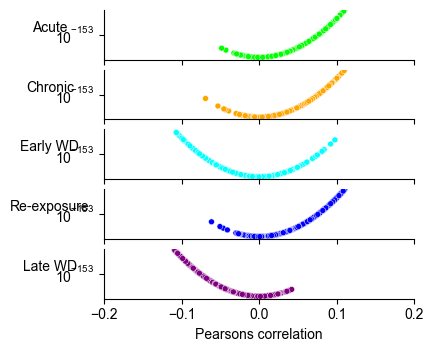

In [326]:
fig,axs = plt.subplots(len(Conditions[1:]),1,figsize= (4,0.75*len(Conditions[1:])),sharey = True,sharex = True)
for idx,condition in enumerate(Conditions[1:]):
    ax = axs[idx]
    sns.scatterplot(data= gene_list,
                x = f'{target_acronym}_{condition}_pearson_rvals',
                y = f'{target_acronym}_{condition}_pearson_pvals',ax = ax,size = 3,color = Condition_color[idx+1],\
                    legend = False)
    ax.set_yscale('log')
    ax.invert_yaxis()
    ax.set_xlim(-0.2,0.2)
    ax.set_xlabel('Pearsons correlation')
    ax.set_ylabel(Condition_figure_name[1+idx],rotation = 0)
    sns.despine()
    #ax.axhline(5e-5)



In [21]:
atlas_df[atlas_df.parent_acronym == 'Acb']

,acronym,id,name,red,green,blue,structure_order,parent_id,parent_acronym,collapse,depth,size_by_voxel,newsize_by_voxel,newsize,ancestor_default_acronym,cleaned_acronym,curated_list
627,AcbC,2074,"Accumbens nucleus, core region",160,232,224,48410,56,Acb,NaN,7,102788.0,102788,2.05576,STR,AcbC,True
628,AcbSh,2006,"Accumbens nucleus, shell region",160,232,224,48420,56,Acb,NaN,7,86994.0,86994,1.73988,STR,AcbSh,True
629,LAcbSh,2007,"Lateral accumbens, shell region",160,232,224,48430,56,Acb,NaN,7,50414.0,50414,1.00828,STR,LAcbSh,True


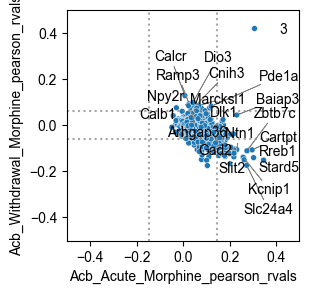

In [415]:
pannel_key = 'B'
condition1 = 'Acute_Morphine'
condition2 = 'Withdrawal_Morphine'
fig,axs = plt.subplots(1,1,figsize = (3,3,))
sns.scatterplot(data= gene_list,
            x = f'{target_acronym}_{condition1}_pearson_rvals',
            y = f'{target_acronym}_{condition2}_pearson_rvals',ax = axs,size = 3)

axs.set_ylim(-.5,.5)
axs.set_xlim(-.5,.5)
# create a list of genes to annotate, top 10
annotation_gene_index = gene_list.sort_values(by = f'{target_acronym}_{condition1}_pearson_rvals',ascending= False).head(10).index.to_list()\
                    + gene_list.sort_values(by = f'{target_acronym}_{condition2}_pearson_rvals',ascending= False).head(10).index.to_list()
threshold1 = gene_list[f'{target_acronym}_{condition1}_pearson_rvals'].std() * 2\
    + gene_list[f'{target_acronym}_{condition1}_pearson_rvals'].mean()
threshold2 = gene_list[f'{target_acronym}_{condition2}_pearson_rvals'].std() * 2\
    + gene_list[f'{target_acronym}_{condition2}_pearson_rvals'].mean()

# Annotating the points with brain region names
texts = []
for i, gene_idx in enumerate(annotation_gene_index):
    gene_symbol = gene_list.loc[gene_idx,'gene_symbol']

    texts.append(axs.text(
        gene_list.loc[gene_idx,f'{target_acronym}_{condition1}_pearson_rvals'],\
        gene_list.loc[gene_idx,f'{target_acronym}_{condition2}_pearson_rvals'],
                            gene_symbol, fontsize=10, alpha=1,color='k'))

# Adjust the text annotations to minimize overlap
adjust_text(texts,ax = axs, arrowprops=dict(color='gray',alpha=1, lw=0.5))

axs.axhline(threshold2,ls = ':',color = 'gray',alpha = 0.7)
axs.axhline(-threshold2,ls = ':',color = 'gray',alpha = 0.7)
axs.axvline(threshold1,ls = ':',color = 'gray',alpha = 0.7)
axs.axvline(-threshold1,ls = ':',color = 'gray',alpha = 0.7)

fig.savefig(os.path.join(analysis_figurepath,f'{tfigure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{tfigure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 216)

array([  2,   7,  11,  90, 165, 243, 363, 367, 399, 401, 423, 483, 484,
       511, 514, 532, 605, 745, 860, 936])

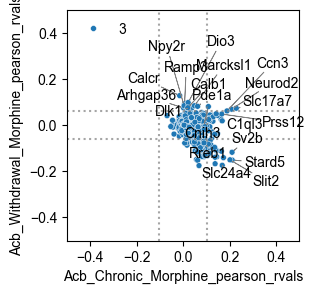

In [417]:
pannel_key = 'C'
condition1 = 'Chronic_Morphine'
condition2 = 'Withdrawal_Morphine'

fig,axs = plt.subplots(1,1,figsize = (3,3,))
sns.scatterplot(data= gene_list,
            x = f'{target_acronym}_{condition1}_pearson_rvals',
            y = f'{target_acronym}_{condition2}_pearson_rvals',ax = axs,size = 3)

axs.set_ylim(-.5,.5)
axs.set_xlim(-.5,.5)
# create a list of genes to annotate, top 10
annotation_gene_index = gene_list.sort_values(by = f'{target_acronym}_{condition1}_pearson_rvals',ascending= False).head(10).index.to_list()\
                    + gene_list.sort_values(by = f'{target_acronym}_{condition2}_pearson_rvals',ascending= False).head(10).index.to_list()
annotation_gene_index = np.unique(annotation_gene_index)
threshold1 = gene_list[f'{target_acronym}_{condition1}_pearson_rvals'].std() * 2\
    + gene_list[f'{target_acronym}_{condition1}_pearson_rvals'].mean()
threshold2 = gene_list[f'{target_acronym}_{condition2}_pearson_rvals'].std() * 2\
    + gene_list[f'{target_acronym}_{condition2}_pearson_rvals'].mean()

# Annotating the points with brain region names
texts = []
for i, gene_idx in enumerate(annotation_gene_index):
    gene_symbol = gene_list.loc[gene_idx,'gene_symbol']

    texts.append(axs.text(
        gene_list.loc[gene_idx,f'{target_acronym}_{condition1}_pearson_rvals'],\
        gene_list.loc[gene_idx,f'{target_acronym}_{condition2}_pearson_rvals'],
                            gene_symbol, fontsize=10, alpha=1,color='k'))

# Adjust the text annotations to minimize overlap
adjust_text(texts,ax = axs, arrowprops=dict(color='gray',alpha=1, lw=0.5))

axs.axhline(threshold2,ls = ':',color = 'gray',alpha = 0.7)
axs.axhline(-threshold2,ls = ':',color = 'gray',alpha = 0.7)
axs.axvline(threshold1,ls = ':',color = 'gray',alpha = 0.7)
axs.axvline(-threshold1,ls = ':',color = 'gray',alpha = 0.7)
fig.savefig(os.path.join(analysis_figurepath,f'{tfigure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{tfigure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 216)

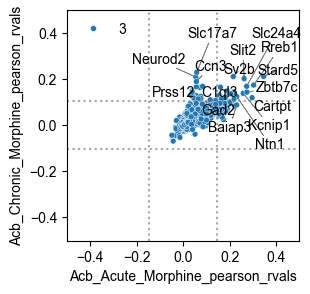

In [418]:
pannel_key = 'D'
condition1 = 'Acute_Morphine'
condition2 = 'Chronic_Morphine'

fig,axs = plt.subplots(1,1,figsize = (3,3,))
sns.scatterplot(data= gene_list,
            x = f'{target_acronym}_{condition1}_pearson_rvals',
            y = f'{target_acronym}_{condition2}_pearson_rvals',ax = axs,size = 3)

axs.set_ylim(-.5,.5)
axs.set_xlim(-.5,.5)
# create a list of genes to annotate, top 10
annotation_gene_index = gene_list.sort_values(by = f'{target_acronym}_{condition1}_pearson_rvals',ascending= False).head(10).index.to_list()\
                    + gene_list.sort_values(by = f'{target_acronym}_{condition2}_pearson_rvals',ascending= False).head(10).index.to_list()
annotation_gene_index = np.unique(annotation_gene_index)

threshold1 = gene_list[f'{target_acronym}_{condition1}_pearson_rvals'].std() * 2\
    + gene_list[f'{target_acronym}_{condition1}_pearson_rvals'].mean()
threshold2 = gene_list[f'{target_acronym}_{condition2}_pearson_rvals'].std() * 2\
    + gene_list[f'{target_acronym}_{condition2}_pearson_rvals'].mean()

# Annotating the points with brain region names
texts = []
for i, gene_idx in enumerate(annotation_gene_index):
    gene_symbol = gene_list.loc[gene_idx,'gene_symbol']

    texts.append(axs.text(
        gene_list.loc[gene_idx,f'{target_acronym}_{condition1}_pearson_rvals'],\
        gene_list.loc[gene_idx,f'{target_acronym}_{condition2}_pearson_rvals'],
                            gene_symbol, fontsize=10, alpha=1,color='k'))

# Adjust the text annotations to minimize overlap
adjust_text(texts,ax = axs, arrowprops=dict(color='gray',alpha=1, lw=0.5))

axs.axhline(threshold2,ls = ':',color = 'gray',alpha = 0.7)
axs.axhline(-threshold2,ls = ':',color = 'gray',alpha = 0.7)
axs.axvline(threshold1,ls = ':',color = 'gray',alpha = 0.7)
axs.axvline(-threshold1,ls = ':',color = 'gray',alpha = 0.7)
fig.savefig(os.path.join(analysis_figurepath,f'{tfigure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{tfigure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 216)

In [412]:
tfigure_key = figure_key + '-supplemental figure1'
pannel_key = 'E'

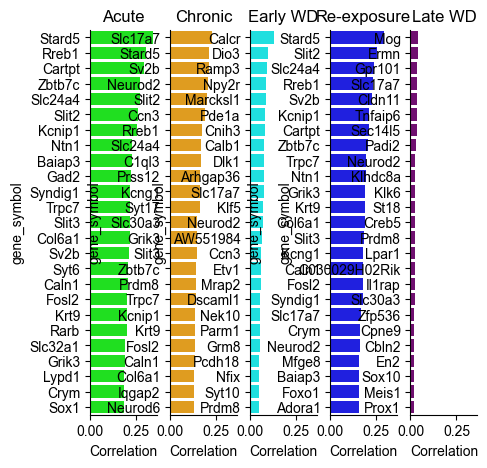

In [413]:
fig,axs = plt.subplots(1,len(Conditions[1:]),figsize = (1 * len(Conditions[1:]),5),sharex = True)
for idx,condition in enumerate(Conditions[1:]):
    ax = axs[idx]
    variable = f'{target_acronym}_{condition}_pearson_rvals'
    sns.barplot(data = gene_list.sort_values(by = variable,ascending = False)[:25],\
        x = variable,y = 'gene_symbol',ax = ax,color = Condition_color[idx+1])
    ax.set_title(Condition_figure_name[idx+1])
    sns.despine()
    ax.set_xlabel('Correlation')
fig.savefig(os.path.join(analysis_figurepath,f'{tfigure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{tfigure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 216)

In [398]:
figure_key = 'Figure7'
pannel_key = 'D'

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_83920\858440428.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = tdf,x = 'coef',y = 'Condition',palette = Condition_color[1:],ax= ax)
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_83920\858440428.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(Condition_figure_name[1:])
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_83920\858440428.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = tdf,x = 'coef',y = 'Condition',palette = Condition_color[1:],ax= ax)
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_83920\85

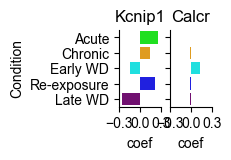

In [404]:
# genes of interest
genes_of_interest = ['Kcnip1','Calcr','Ccn3'][:-1]

fig,axs = plt.subplots(1,len(genes_of_interest),sharex = True,sharey = True,figsize=  (1.2,1))
for idx,gene in enumerate(genes_of_interest):
    ax = axs[idx]
    tdf = gene_list.loc[gene_list.gene_symbol == gene,['gene_symbol']+[f'{target_acronym}_{f}_pearson_rvals' for f in Conditions[1:]]].set_index('gene_symbol').stack().reset_index().rename(columns = {'level_1':'Condition',0:'coef'})
    sns.barplot(data = tdf,x = 'coef',y = 'Condition',palette = Condition_color[1:],ax= ax)
    ax.set_yticklabels(Condition_figure_name[1:])
    ax.set_xticks([-.3,0,.3])
    sns.despine()
    ax.set_title(gene)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 216)

## Plot the actual gene images

In [368]:
# target site can be experiment specific
target_site_acronym = 'Acb'
target_site_id = atlas_df.loc[atlas_df.acronym == target_site_acronym,'id'].values[0]
target_site_subids = create_mask_for_region.get_subregions(atlas_df,target_site_id,return_original=True)['id'].values


In [369]:
# collect all the z positions where there is the target site
zs = np.array([])
for ID in target_site_subids:
    z_,y_,x_ = np.where(atlas_img == ID)
    zs = np.concatenate([zs,z_])
# find the center of mass of the OFC
z_unique = np.unique(zs).astype('uint16')
z_center = int(np.mean(zs))


In [389]:
# subset to NAc region
xslice = slice(325-120,325,)
yslice = slice(240,240+120)

In [383]:
import numpy as np

def set_transparency(rgba_img, mask):
    """
    Applies a transparency mask to an existing RGBA image.

    Parameters:
    - rgba_img: np.ndarray of shape (H, W, 4), dtype uint8
        The input RGBA image.
    - mask: np.ndarray of shape (H, W), dtype bool
        Boolean mask where True means the pixel should be transparent.

    Returns:
    - np.ndarray of shape (H, W, 4), modified RGBA image.
    """
    if rgba_img.shape[-1] != 4:
        raise ValueError("Input image must be RGBA (shape must be H x W x 4).")
    if rgba_img.shape[:2] != mask.shape:
        raise ValueError("Mask shape must match image height and width.")

    # Copy to avoid modifying the original
    result = rgba_img.copy()
    result[mask, 3] = 0  # Set alpha to 0 (transparent) where mask is True
    return result


Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x000001D0E1989EE0>
Traceback (most recent call last):
  File "c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\_weakrefset.py", line 40, in _remove
    self = selfref()
           ^^^^^^^^^
KeyboardInterrupt: 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow

KeyboardInterrupt: 

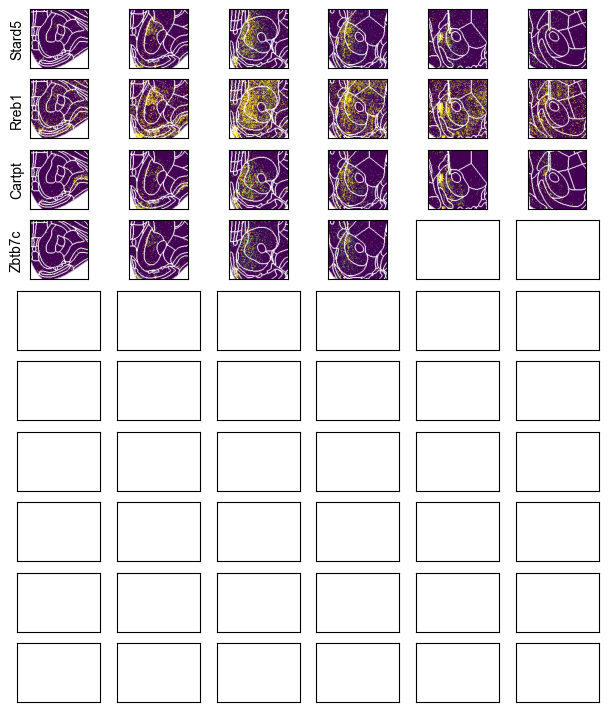

In [396]:
# plot the spatial distribution of double+ cells for each subject
import contour_visualization2 as cv2
tfigure_key = figure_key + '-supplemental figure1'
pannel_key = 'A'

for condition in Conditions[1:]:
    # create a list of genes to annotate, top 10
    annotation_gene_index = gene_list.sort_values(by = f'{target_acronym}_{condition}_pearson_rvals',ascending= False).head(10).index.to_list()

    fig, axs = plt.subplots(len(annotation_gene_index), len(z_unique[::5]), figsize=(len(z_unique[::5])*1.25, len(annotation_gene_index)-1), sharex=True,sharey = True)


    for cidx, gene_idx in enumerate(annotation_gene_index):
        theatmap = gene_matrix[gene_idx,:].reshape(atlas_img.shape).compute()
        gene_symbol = gene_list.loc[gene_idx,'gene_symbol']
        #theatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{condition}_betas.npy'))
        #theatmap = np.mean(np.array([heatmap_dict[condition][subject] for subject in heatmap_dict[condition].keys()]),axis = 0)
        __,overlayed_image = cv2.overlap_contour(theatmap,contour_img,\
            cmin =  -0, cmax = 1,\
            outputpath = None,colormap = plt.cm.viridis)
        for idx, curated_zplane in enumerate(z_unique[::5]):
            ax = axs[cidx, idx]
            trans_img = set_transparency(overlayed_image[curated_zplane,:,:], (atlas_img==0)[curated_zplane,:,:])
            ax.imshow(trans_img[yslice,xslice])
            #ax.imshow(overlayed_image[curated_zplane,yslice,xslice],cmap = 'viridis')
            ax.set_xticks([])  # Remove x ticks
            ax.set_yticks([])  # Remove y ticks
            #ax.axis('off')
            if idx == 0:
                ax.set_ylabel(gene_symbol, color='black', )
            else:
                ax.set_ylabel('', color='black',)
            ax.invert_xaxis()
    fig.savefig(os.path.join(analysis_figurepath,f'{tfigure_key}{pannel_key}_{condition}.png'),bbox_inches='tight',dpi = 1024)
    fig.savefig(os.path.join(analysis_figurepath,f'{tfigure_key}{pannel_key}_{condition}.svg'),bbox_inches='tight',dpi = 1024)

# Prepare spatial neural data

The spatial data (betacoef from linear regression/factors from semi-nnmf) are first averaged across hemisphere and then downsampled.

## Prepare hemi atlas

In [110]:
# create a hemisphere brain atlas
hemi_atlas_img = atlas_img[:,:,:atlas_img.shape[2]//2]
#hemi_atlas_img = np.reshape(hemi_atlas_img.T.flatten().T,hemi_atlas_img.shape[::-1])

## For betacoef

In [20]:
'''# read the beatcoef array
condition = 'Withdrawal_Morphine'
for condition in Conditions:
    betacoef = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{condition}_betas.npy'))
    # preprocess betacoef to match the hemisphere data
    betacoef = (betacoef[:,:,:atlas_img.shape[2]//2] + betacoef[:,:,atlas_img.shape[2]//2:][:,:,::-1])/2
    betacoef = betacoef.T.flatten()

    betacoef_reshaped = da.from_array(
        np.reshape(betacoef, hemi_atlas_img.shape), chunks=(100, 100, 50)
    )
    
    # Define downsampling factors
    downsample_factors = (1, 5, 5, 2)  # Keeping gene_dim the same

    # Convert tuple to dictionary format for da.coarsen()
    downsample_dict = {1: 5, 2: 5, 3: 2}  # Apply downsampling only on spatial axes

    # Downsample using dask's coarsen function with mean pooling
    
    betacoef_downsampled = da.coarsen(np.mean, betacoef_reshaped, {0: 5, 1: 5, 2: 2}, trim_excess=True)

    betacoef_downsampled = betacoef_downsampled.flatten().compute()

    # Check shapes of downsampled arrays
    print("Downsampled Betacoef Shape:", betacoef_downsampled.shape)
    np.save(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f"{condition}_betacoef_downsampled.npy"),betacoef_downsampled)'''

<>:1: SyntaxWarning: invalid escape sequence '\L'
<>:1: SyntaxWarning: invalid escape sequence '\L'
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_83920\782252609.py:1: SyntaxWarning: invalid escape sequence '\L'
  '''# read the beatcoef array


'# read the beatcoef array\ncondition = \'Withdrawal_Morphine\'\nfor condition in Conditions:\n    betacoef = np.load(os.path.join(r"\\10.159.50.7\\LabCommon\\Ken\\data\\Opioid_cFos\result",f\'{condition}_betas.npy\'))\n    # preprocess betacoef to match the hemisphere data\n    betacoef = (betacoef[:,:,:atlas_img.shape[2]//2] + betacoef[:,:,atlas_img.shape[2]//2:][:,:,::-1])/2\n    betacoef = betacoef.T.flatten()\n\n    betacoef_reshaped = da.from_array(\n        np.reshape(betacoef, hemi_atlas_img.shape), chunks=(100, 100, 50)\n    )\n    \n    # Define downsampling factors\n    downsample_factors = (1, 5, 5, 2)  # Keeping gene_dim the same\n\n    # Convert tuple to dictionary format for da.coarsen()\n    downsample_dict = {1: 5, 2: 5, 3: 2}  # Apply downsampling only on spatial axes\n\n    # Downsample using dask\'s coarsen function with mean pooling\n    \n    betacoef_downsampled = da.coarsen(np.mean, betacoef_reshaped, {0: 5, 1: 5, 2: 2}, trim_excess=True)\n\n    betacoef_downsam

## For factors

In [21]:
'''# read the factor array
factor_path = os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\spatial_clustering_results\2025_04_02-12_34","npy")
for fidx in range(22):
    factor_array = np.load(os.path.join(factor_path,f'factor{fidx}.npy'))
    # preprocess factor_array to match the hemisphere data
    factor_array = (factor_array[:,:,:atlas_img.shape[2]//2] + factor_array[:,:,atlas_img.shape[2]//2:][:,:,::-1])/2
    factor_array = factor_array.T.flatten()

    factor_array_reshaped = da.from_array(
        np.reshape(factor_array, hemi_atlas_img.shape), chunks=(100, 100, 50)
    )
    
    # Define downsampling factors
    downsample_factors = (1, 5, 5, 2)  # Keeping gene_dim the same

    # Convert tuple to dictionary format for da.coarsen()
    downsample_dict = {1: 5, 2: 5, 3: 2}  # Apply downsampling only on spatial axes

    # Downsample using dask's coarsen function with mean pooling
    
    factor_array_downsampled = da.coarsen(np.mean, factor_array_reshaped, {0: 5, 1: 5, 2: 2}, trim_excess=True)

    factor_array_downsampled = factor_array_downsampled.flatten().compute()

    # Check shapes of downsampled arrays
    print("Downsampled factor_array Shape:", factor_array_downsampled.shape)
    np.save(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f"factor{fidx}_array_downsampled.npy"),factor_array_downsampled)'''

<>:1: SyntaxWarning: invalid escape sequence '\L'
<>:1: SyntaxWarning: invalid escape sequence '\L'
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_83920\2205684751.py:1: SyntaxWarning: invalid escape sequence '\L'
  '''# read the factor array


'# read the factor array\nfactor_path = os.path.join(r"\\10.159.50.7\\LabCommon\\Ken\\data\\Opioid_cFos\\spatial_clustering_results\x825_04_02-12_34","npy")\nfor fidx in range(22):\n    factor_array = np.load(os.path.join(factor_path,f\'factor{fidx}.npy\'))\n    # preprocess factor_array to match the hemisphere data\n    factor_array = (factor_array[:,:,:atlas_img.shape[2]//2] + factor_array[:,:,atlas_img.shape[2]//2:][:,:,::-1])/2\n    factor_array = factor_array.T.flatten()\n\n    factor_array_reshaped = da.from_array(\n        np.reshape(factor_array, hemi_atlas_img.shape), chunks=(100, 100, 50)\n    )\n    \n    # Define downsampling factors\n    downsample_factors = (1, 5, 5, 2)  # Keeping gene_dim the same\n\n    # Convert tuple to dictionary format for da.coarsen()\n    downsample_dict = {1: 5, 2: 5, 3: 2}  # Apply downsampling only on spatial axes\n\n    # Downsample using dask\'s coarsen function with mean pooling\n    \n    factor_array_downsampled = da.coarsen(np.mean, facto

In [22]:
condition_key = 'NAc_'
gene_list= pd.read_csv(os.path.join(analysis_resultpath,f'{condition_key}_gene_list.csv'),index_col = False)

# In situ analysis

## Preparation

In [ ]:
# read a meta file for sections
section_metadf = pd.read_excel(os.path.join(metapath,"NAc_ISH_meta_v3.xlsx"),engine='openpyxl')
section_metadf = section_metadf[section_metadf.Usable]
section_metadf = section_metadf.rename(columns = {'Section':'section'})
#filter_list = section_metadf[['ID','Check']].rename(columns = {'Check':'section'})
#filter_list = [tuple(f) for f in filter_list.values]


In [ ]:
# read the dataframe
total_merge_cell_df = pd.read_csv(os.path.join(analysis_resultpath,f'{figure_key}_total_merge_cell_df.csv'),index_col = 0)

# drop the background
total_merge_cell_df = total_merge_cell_df.drop(0)

# drop the conditions that are not in the analysis plan
insitu_Conditions = ['Saline','Acute_Morphine', 'Chronic_Morphine', 'Withdrawal_Morphine']
total_merge_cell_df = total_merge_cell_df[total_merge_cell_df.Condition.isin(insitu_Conditions)]


In [ ]:
# subset the dataframe to the ones that are usable
total_merge_cell_df.section = total_merge_cell_df.section.astype('int')
total_merge_cell_df = section_metadf.set_index(['ID','section'])[['Usable']].join(total_merge_cell_df.set_index(['ID','section'])).reset_index()


In [ ]:
# count threshold
count_threshold = 5 # dots

In [ ]:
# gene
genes = [f.replace('_FFT_intensity','') for f in total_merge_cell_df.columns if '_FFT_intensity' in f]
gene = 'Fos'

# calculate the positive cells
for gene in genes:
    total_merge_cell_df[f'{gene}_cells'] = total_merge_cell_df[f'{gene}_regressed_counts'] > count_threshold
    total_merge_cell_df[f'{gene}_sum_raw_intensity'] = total_merge_cell_df[f'{gene}_raw_intensity']*total_merge_cell_df[f'{gene}_counts']

In [ ]:
# add core/shell info to the dataframe
core_cell_df = total_merge_cell_df[(total_merge_cell_df.Core_cells == True)&(total_merge_cell_df.Shell_cells == False)]
shell_cell_df = total_merge_cell_df[(total_merge_cell_df.Core_cells == False)&(total_merge_cell_df.Shell_cells == True)]

In [ ]:
# select the dataframe to analyze
tcell_df = core_cell_df
for idx,tcell_df in enumerate([core_cell_df, shell_cell_df]):
    t_group_cell_df = tcell_df.groupby(['Condition','ID','section']).mean().reset_index()
    if idx == 0:
        group_cell_df = t_group_cell_df
    else:
        group_cell_df = pd.concat([group_cell_df,t_group_cell_df],axis = 0)
    

In [ ]:
# subset the dataframe to the ones that are usable
group_cell_df.section = group_cell_df.section.astype('int')
#group_cell_df = section_metadf.set_index(['ID','section'])[['Usable']].join(group_cell_df.set_index(['ID','section'])).reset_index()
# write the result
group_cell_df.to_csv(os.path.join(analysis_resultpath,f'{figure_key}_group_cell_df.csv'),index = False)

## Figure J

In [ ]:
pannel_key = 'J'

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\2038603657.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\2038603657.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\2038603657.py:25: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\2038603657.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['S

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Saline vs. Acute_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:8.963e-03 t=-2.789e+00
Saline vs. Chronic_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:4.278e-04 t=-3.758e+00
Saline vs. Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:8.239e-05 t=-4.339e+00


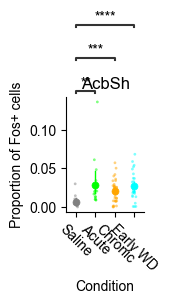

In [42]:
# plot an overlay of stripplot and pointplot showing Core_cells == 0 cells, Condition as x, Fos_cells as y
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for Core_cells == 0
filtered_data = group_cell_df[group_cell_df.Core_cells == 0]

# Create the plot
fig, ax = plt.subplots(figsize=(1.,1.5))

# Overlay stripplot
sns.stripplot(
    data=filtered_data,
    x='Condition',
    y='Fos_cells',
    order=insitu_Conditions,
    dodge=False,
    ax=ax,
    alpha = 0.5,
    size= 2,
    palette=['gray', 'lime', 'orange', 'cyan']
)

# Overlay pointplot
sns.pointplot(
    data=filtered_data,
    x='Condition',
    y='Fos_cells',
    order=insitu_Conditions,
    ax=ax,
    linewidth=0.7,
    errwidth = 1,
    markersize= 5,
    palette=['gray', 'lime', 'orange', 'cyan']
)

# Customize the plot
sns.despine()
ax.set_xticklabels(['Saline', 'Acute', 'Chronic', 'Early WD'], rotation=-45)
ax.set_ylabel('Proportion of Fos+ cells')
ax.set_title('AcbSh')

from statannotations.Annotator import Annotator
pairs = [("Saline",c) for c in ['Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine']]

annotator = Annotator(ax, pairs, data=filtered_data,
    x='Condition',
    y='Fos_cells', order=insitu_Conditions)
annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()

fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'), dpi=300, bbox_inches='tight')

## Figure K

In [43]:
pannel_key = 'K'

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\664181053.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\664181053.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\664181053.py:25: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\664181053.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Salin

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Saline vs. Acute_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:5.477e-02 t=-1.996e+00
Saline vs. Chronic_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:2.125e-02 t=-2.374e+00
Saline vs. Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:5.556e-05 t=-4.463e+00


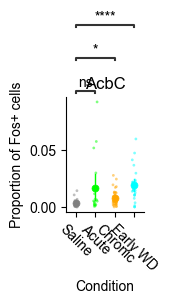

In [44]:
# plot an overlay of stripplot and pointplot showing Core_cells == 1 cells, Condition as x, Fos_cells as y
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for Core_cells == 0
filtered_data = group_cell_df[group_cell_df.Core_cells == 1]

# Create the plot
fig, ax = plt.subplots(figsize=(1.,1.5))

# Overlay stripplot
sns.stripplot(
    data=filtered_data,
    x='Condition',
    y='Fos_cells',
    order=insitu_Conditions,
    dodge=False,
    ax=ax,
    alpha = 0.5,
    size= 2,
    palette=['gray', 'lime', 'orange', 'cyan']
)

# Overlay pointplot
sns.pointplot(
    data=filtered_data,
    x='Condition',
    y='Fos_cells',
    order=insitu_Conditions,
    ax=ax,
    linewidth=0.7,
    errwidth = 1,
    markersize= 5,
    palette=['gray', 'lime', 'orange', 'cyan']
)

# Customize the plot
sns.despine()
ax.set_xticklabels(['Saline', 'Acute', 'Chronic', 'Early WD'], rotation=-45)
ax.set_ylabel('Proportion of Fos+ cells')
ax.set_title('AcbC')

from statannotations.Annotator import Annotator
pairs = [("Saline",c) for c in ['Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine']]

annotator = Annotator(ax, pairs, data=filtered_data,
    x='Condition',
    y='Fos_cells', order=insitu_Conditions)
annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()


fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'), dpi=300, bbox_inches='tight')

In [48]:
# Group Kim_z into anterior and posterior regions
def assign_region(kim_z):
    if kim_z in [88, 90, 92,94,96,]:
        return 0
    elif kim_z in [98,100, 102,104,106]:
        return 1
    else:
        return 'Unknown'

# Apply the function to create a new column
total_merge_cell_df['Region_idx'] = total_merge_cell_df['Kim_z'].apply(assign_region)
group_cell_df['Region_idx'] = group_cell_df['Kim_z'].apply(assign_region)


## Check the overlap between Calcr and Kcnip1

In [51]:
ZtoAP = pd.DataFrame(np.unique(section_metadf[['AP','Kim_z']].values,axis = 0),columns = ['AP','Kim_z']).set_index('Kim_z')

In [53]:
pannel_key = 'H+I'

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\3600801890.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Region'] = filtered_data.apply(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\3600801890.py:25: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\3600801890.py:25: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\3600801890.py:25: FutureWarning: 

The `errwidth` parameter is deprecated. And wil

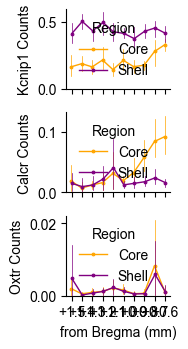

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for Kim_z between 88 and 104
filtered_data = group_cell_df[(group_cell_df['Kim_z'] >= 88) & (group_cell_df['Kim_z'] <= 106)]
# convert the Kim_z to AP mm
AP_text = [f'+{ZtoAP.loc[f,:].values[0]}' for f in np.sort(filtered_data.Kim_z.unique())]
# Add a new column to distinguish Core and Shell
filtered_data['Region'] = filtered_data.apply(
    lambda row: 'Core' if row['Core_cells'] else ('Shell' if row['Shell_cells'] else 'Unknown'), axis=1
)

# Remove rows with 'Unknown' region
filtered_data = filtered_data[filtered_data['Region'] != 'Unknown']

# Define the genes to plot
genes = ['Kcnip1', 'Calcr', 'Oxtr']

# Create a figure with subplots for each gene
fig, axs = plt.subplots(len(genes), 1, figsize=(2, len(genes) * 1.2), sharex=True)

# Iterate over genes and plot for Core and Shell in the same plot
for i, gene in enumerate(genes):
    ax = axs[i]
    sns.pointplot(
        data=filtered_data,
        x='Kim_z',
        y=f'{gene}_cells',
        hue='Region',
        dodge=True,
        ax=ax,
        errwidth=0.5,
        linewidth = 1,
        markersize = 2,
        markers='o',
        palette=['orange', 'purple']  # Keep the same color for points
    )
    #ax.set_title(f'{gene} Distribution in Core and Shell')
    ax.set_xlabel('from Bregma (mm)')
    ax.set_ylabel(f'{gene} Counts')
    sns.despine()
    ax.set_ylim(0,)

# Adjust layout
plt.tight_layout()
ax.set_xticklabels(AP_text)
# Save the figure
fig.savefig(os.path.join(analysis_figurepath, f'{figure_key}{pannel_key}.png'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(analysis_figurepath, f'{figure_key}{pannel_key}.pdf'), dpi=300, bbox_inches='tight')


## Figure M

In [60]:
# select the dataframe to analyze
tcell_df = core_cell_df
for idx,tcell_df in enumerate([core_cell_df, shell_cell_df]):
    
    # get the fos counts by gene
    for gene in genes:
        if gene == 'Fos':
            continue
        #print(gene)
        tcell_df.loc[:,f'Fos_{gene}_cells'] = False
        tcell_df.loc[(tcell_df.Fos_cells) & (tcell_df[f'{gene}_regressed_counts'] > count_threshold),f'Fos_{gene}_cells'] = True

    t_group_cell_df = tcell_df.groupby(['Condition','ID','section']).mean().reset_index()
    if idx == 0:
        Fos_group_cell_df = t_group_cell_df
    else:
        Fos_group_cell_df = pd.concat([Fos_group_cell_df,t_group_cell_df],axis = 0)
    

In [61]:
# Group Kim_z into anterior and posterior regions
def assign_region(kim_z):
    if kim_z in [88, 90, 92,94,96,]:
        return 0
    elif kim_z in [98,100, 102,104,106]:
        return 1
    else:
        return 'Unknown'

# Apply the function to create a new column
Fos_group_cell_df['Region_idx'] = Fos_group_cell_df['Kim_z'].apply(assign_region)


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\785079234.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\785079234.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\785079234.py:28: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\785079234.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Salin

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Saline vs. Acute_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:1.630e-02 t=-2.540e+00
Saline vs. Chronic_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:4.749e-04 t=-3.725e+00
Saline vs. Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:2.852e-04 t=-3.943e+00


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\785079234.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\785079234.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\785079234.py:28: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\785079234.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Salin

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Saline vs. Acute_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:6.177e-01 t=5.042e-01
Saline vs. Chronic_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:6.473e-01 t=4.601e-01
Saline vs. Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:1.568e-01 t=-1.441e+00


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\785079234.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\785079234.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\785079234.py:28: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\785079234.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Salin

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Saline vs. Acute_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:6.330e-01 t=-4.822e-01
Saline vs. Chronic_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:1.450e-01 t=-1.479e+00
Saline vs. Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:5.937e-01 t=-5.374e-01


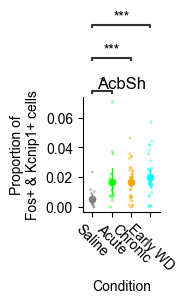

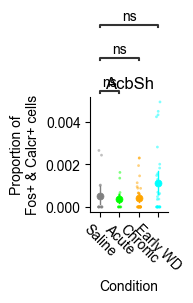

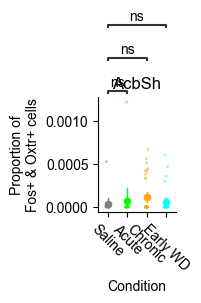

In [63]:
# plot an overlay of stripplot and pointplot showing Core_cells == 0 cells, Condition as x, Fos_cells as y
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for Core_cells == 0
filtered_data = Fos_group_cell_df[Fos_group_cell_df.Core_cells == 0]


gene = 'Kcnip1'
for gene in ['Kcnip1','Calcr','Oxtr']:
    # Create the plot
    fig, ax = plt.subplots(figsize=(1.,1.5))

    # Overlay stripplot
    sns.stripplot(
        data=filtered_data,
        x='Condition',
        y=f'Fos_{gene}_cells',
        order=insitu_Conditions,
        dodge=False,
        ax=ax,
        alpha = 0.5,
        size= 2,
        palette=['gray', 'lime', 'orange', 'cyan']
    )

    # Overlay pointplot
    sns.pointplot(
        data=filtered_data,
        x='Condition',
        y=f'Fos_{gene}_cells',
        order=insitu_Conditions,
        ax=ax,
        linewidth=0.7,
        errwidth = 1,
        markersize= 5,
        palette=['gray', 'lime', 'orange', 'cyan']
    )

    # Customize the plot
    sns.despine()
    ax.set_xticklabels(['Saline', 'Acute', 'Chronic', 'Early WD'], rotation=-45)
    ax.set_ylabel(f'Proportion of\nFos+ & {gene}+ cells')
    ax.set_title('AcbSh')

    from statannotations.Annotator import Annotator
    pairs = [("Saline",c) for c in ['Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine']]

    annotator = Annotator(ax, pairs, data=filtered_data,
        x='Condition',
        y=f'Fos_{gene}_cells', order=insitu_Conditions)
    annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
    annotator.configure(comparisons_correction="BH", correction_format="replace")
    annotator.apply_and_annotate()

    # save the figures
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{gene}.png'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{gene}.pdf'), dpi=300, bbox_inches='tight')


## Figure L

In [64]:
pannel_key = 'L'

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\1737824299.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\1737824299.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\1737824299.py:28: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\1737824299.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['S

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Saline vs. Acute_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:1.868e-01 t=-1.350e+00
Saline vs. Chronic_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:1.694e-01 t=-1.393e+00
Saline vs. Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:7.810e-04 t=-3.610e+00


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\1737824299.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\1737824299.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\1737824299.py:28: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\1737824299.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['S

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Saline vs. Acute_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:8.316e-01 t=-2.145e-01
Saline vs. Chronic_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:8.431e-01 t=1.990e-01
Saline vs. Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:2.323e-02 (ns) t=-2.352e+00


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\1737824299.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\1737824299.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\1737824299.py:28: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_37016\1737824299.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['S

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Saline vs. Acute_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:1.036e-01 t=-1.677e+00
Saline vs. Chronic_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:2.487e-01 t=-1.166e+00
Saline vs. Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:3.032e-01 t=-1.042e+00


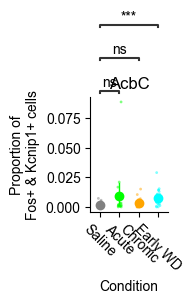

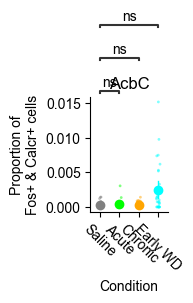

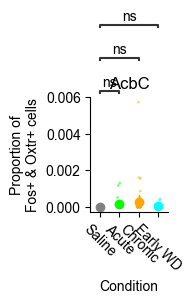

In [65]:
# plot an overlay of stripplot and pointplot showing Core_cells == 0 cells, Condition as x, Fos_cells as y
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for Core_cells == 0
filtered_data = Fos_group_cell_df[Fos_group_cell_df.Core_cells == 1]


gene = 'Kcnip1'
for gene in ['Kcnip1','Calcr','Oxtr']:
    # Create the plot
    fig, ax = plt.subplots(figsize=(1.,1.5))

    # Overlay stripplot
    sns.stripplot(
        data=filtered_data,
        x='Condition',
        y=f'Fos_{gene}_cells',
        order=insitu_Conditions,
        dodge=False,
        ax=ax,
        alpha = 0.5,
        size= 2,
        palette=['gray', 'lime', 'orange', 'cyan']
    )

    # Overlay pointplot
    sns.pointplot(
        data=filtered_data,
        x='Condition',
        y=f'Fos_{gene}_cells',
        order=insitu_Conditions,
        ax=ax,
        errwidth = 1,
        markersize= 5,
        palette=['gray', 'lime', 'orange', 'cyan']
    )

    # Customize the plot
    sns.despine()
    ax.set_xticklabels(['Saline', 'Acute', 'Chronic', 'Early WD'], rotation=-45)
    ax.set_ylabel(f'Proportion of\nFos+ & {gene}+ cells')
    ax.set_title('AcbC')

    from statannotations.Annotator import Annotator
    pairs = [("Saline",c) for c in ['Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine']]

    annotator = Annotator(ax, pairs, data=filtered_data,
        x='Condition',
        y=f'Fos_{gene}_cells', order=insitu_Conditions)
    annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
    annotator.configure(comparisons_correction="BH", correction_format="replace")
    annotator.apply_and_annotate()

    # save the figures
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{gene}.png'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{gene}.pdf'), dpi=300, bbox_inches='tight')
    